In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm

In [32]:
df = pd.read_csv(f'../data/U/2020-10-01 - 2021-10-02.csv', index_col=0, parse_dates=['time'], dayfirst=True)
df.head()

,figi,interval,o,c,h,l,v,time
0,BBG0056JW5G6,15min,99.70,99.70,99.70,99.70,2,2021-06-10 13:30:00+00:00
1,BBG0056JW5G6,15min,100.00,99.99,100.00,99.93,9,2021-06-10 13:45:00+00:00
2,BBG0056JW5G6,15min,100.17,99.93,100.51,99.93,11,2021-06-10 14:00:00+00:00
3,BBG0056JW5G6,15min,99.80,99.56,99.80,99.56,2,2021-06-10 14:15:00+00:00
4,BBG0056JW5G6,15min,99.00,99.00,99.00,99.00,1,2021-06-10 14:30:00+00:00


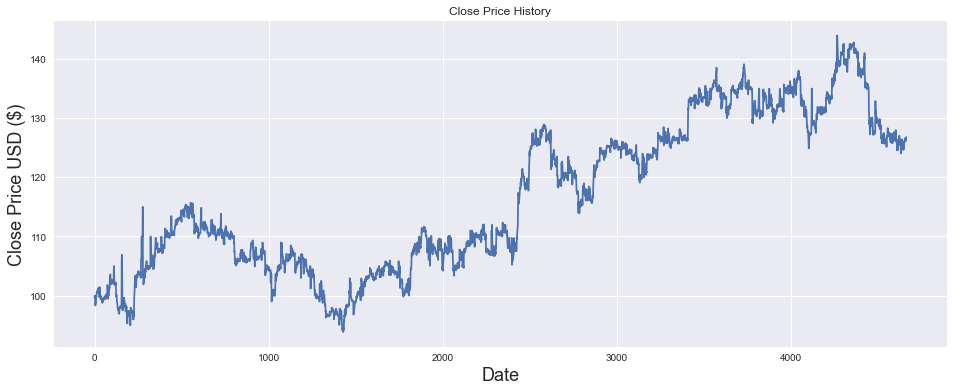

In [33]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['c'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [34]:
test_size = 74
data = df.filter('c')
dataset = data.values
train_df = dataset[:-test_size]
test_df = dataset[-test_size:]

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_df)
scaled_data

array([[0.1165436 ],
       [0.12233087],
       [0.12113351],
       ...,
       [0.64997007],
       [0.65895031],
       [0.6497705 ]])

In [55]:
x_train = []
y_train = []

for i in range(test_size, len(scaled_data)):
    x_train.append(scaled_data[i - test_size:i])
    y_train.append(scaled_data[i])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM
from tensorflow.keras import regularizers

model=Sequential()
model.add(GRU(128,return_sequences=True, activity_regularizer=regularizers.l2(1e-5), input_shape=(74,1)))
model.add(GRU(64,return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
model.add(GRU(64,return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
model.add(GRU(64,return_sequences=True, activity_regularizer=regularizers.l2(1e-5)))
model.add(GRU(32, activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.22))
model.add(Dense(1, activation='relu', activity_regularizer=regularizers.l2(1e-5)))

model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
%%time

model.fit(x_train, y_train, batch_size=1, epochs=1)

4514/4514 [==============================] - 158s 34ms/step - loss: 0.0061

In [91]:
x_test = x_train[len(x_train) - 1:].copy()
predictions = []

for i in range(len(test_df)):
    predictions.append(model.predict(x_test).tolist())
    x_test = np.append(x_test[0][1:], predictions[i])
    x_test = x_test.reshape(1, 74, 1)

In [75]:
predictions = np.array(predictions)
predictions = predictions.reshape(74, 1)
predictions = scaler.inverse_transform(predictions)

In [76]:
train = data[:-test_size]
valid = data[-test_size:]
valid['Predicted'] = predictions
valid

C:\Users\spark\AppData\Local\Temp/ipykernel_7348/1580747980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicted'] = predictions


,c,Predicted
4588,126.88,124.881361
4589,127.10,123.546885
4590,127.62,122.532088
4591,127.08,121.631434
4592,127.30,120.790706
...,...,...
4657,126.24,106.101246
4658,126.59,106.080129
4659,126.20,106.060200
4660,126.70,106.041394


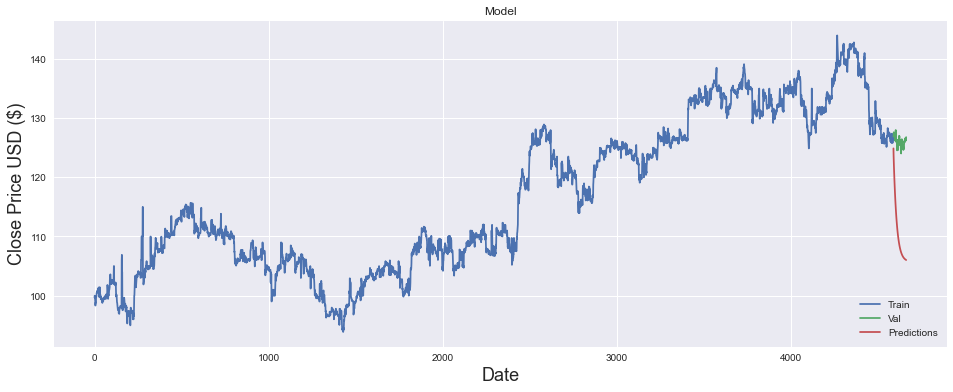

In [77]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['c'])
plt.plot(valid[['c', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

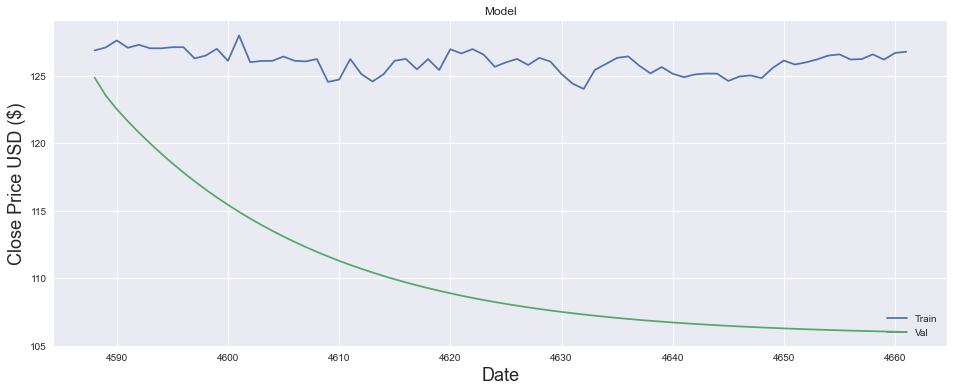

In [78]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['c', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()